# Facial Keypoints Detection

In [1]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pylab as plot
import pandas as pd
import sys, os
import torch
import torch.utils.data
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import copy

In [2]:
fname = 'training.csv'
df = pd.read_csv(fname)

df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

#descartando dados incompletos
df = df.dropna()

#normalizando
X = np.vstack(df['Image'].values)/255.
X = X.astype(np.float32)

y = df[df.columns[:-1]].values.astype(np.float32)

X_numpy, y_numpy = X.reshape(-1,1,96,96), y

In [3]:
reduced = False
if reduced:
    X_numpy = X_numpy[:500,:]
    y_numpy = y_numpy[:500,:]

print('Dados de treinamento e validação:', X_numpy.shape, y_numpy.shape)

(2140, 1, 96, 96) (2140, 30)


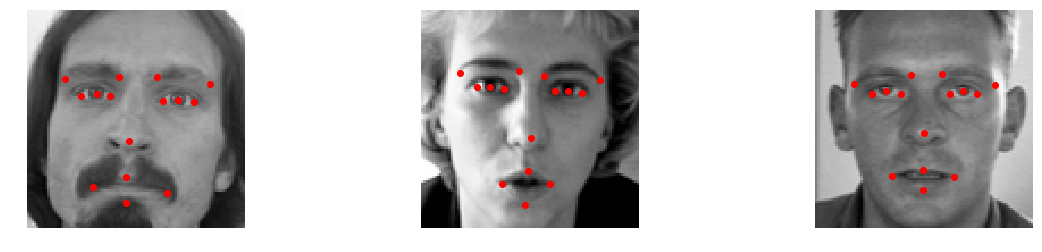

In [4]:
plot.figure(figsize=(20, 4))
plot.gray()
for i in range(3):
    imgs = X_numpy[i].reshape(96,96)
    plot.subplot(1, 3, i+1)
    points = y_numpy[i].reshape(15,2)
    plot.scatter(points[:,0], points[:,1], c='r')
    plot.imshow(imgs)
    plot.axis('off')
plot.show()

In [5]:
X = torch.from_numpy(X_numpy).type(torch.FloatTensor)
y = torch.from_numpy((y_numpy-48)/48).type(torch.FloatTensor)
print(X.shape, y.shape)

torch.Size([2140, 1, 96, 96]) torch.Size([2140, 30])


In [6]:
val_split = 0.01
X_train = X[:int(len(X)*(1 - val_split)),:]
y_train = y[:int(len(X)*(1 - val_split)),:]

X_val = X[int(len(X)*(1 - val_split)):,:]
y_val = y[int(len(X)*(1 - val_split)):,:]

print(X_train.shape, X_train.shape, X_val.shape, y_val.shape)

torch.Size([2118, 1, 96, 96]) torch.Size([2118, 1, 96, 96]) torch.Size([22, 1, 96, 96]) torch.Size([22, 30])


In [7]:
trainset = torch.utils.data.TensorDataset(X_train, y_train)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=2)

valset = torch.utils.data.TensorDataset(X_val, y_val)

valloader = torch.utils.data.DataLoader(valset,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=2)


In [9]:
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(1,32,kernel_size=(3,3)),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Conv2d(32,32,kernel_size=(3,3)),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.MaxPool2d(2,2),     
            torch.nn.Dropout(0.5),
            torch.nn.MaxPool2d(2,2),     
            torch.nn.Dropout(0.5)
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(23 * 23 * 32, 128), #imagem 14x14, 32 canais
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 30)
        )

    def forward(self,x):
        x = self.features(x)
        x = x.view(-1, 23 * 23 * 32)
        x = self.classifier(x)
        return x
    
model = Net()
print(model)

Net (
  (features): Sequential (
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU ()
    (2): Dropout (p = 0.5)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU ()
    (5): Dropout (p = 0.5)
    (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (7): Dropout (p = 0.5)
    (8): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (9): Dropout (p = 0.5)
  )
  (classifier): Sequential (
    (0): Linear (16928 -> 128)
    (1): ReLU ()
    (2): Dropout (p = 0.5)
    (3): Linear (128 -> 30)
  )
)


In [10]:
def train(model, trainloader, valloader, epochs, patience):
    
    last_epoch = 0
    last_loss = 0
    last_loss_val = 0
    best_loss = 0
    patience_count = 0
    best_model = []
    loss_fn = torch.nn.MSELoss()
    loss_fn_val= torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    history_loss = np.empty(epochs)
    history_loss_val = np.empty(epochs)

    for t in range(epochs):
        print('Epoch {}/{}'.format(t, epochs - 1))
        print('-' * 10)

        for k, data in enumerate(trainloader):
            sys.stdout.write('%d/%d train mini-batch\r' % (k,len(trainloader)))
            
            inputs, labels = data
            
            inputs, labels = Variable(inputs), Variable(labels)
            
            predict = model(inputs)

            loss = loss_fn(predict, labels)

            optimizer.zero_grad()
            
            loss.backward()

            optimizer.step()
        
        for k, data in enumerate(valloader):
            sys.stdout.write('%d/%d validation mini-batch\r' % (k,len(valloader)))
            
            inputs, labels = data
            
            inputs, labels = Variable(inputs), Variable(labels)
            
            predict = model(inputs)
            
            loss_val = loss_fn_val(predict, labels)
            

        history_loss[t] = last_loss = loss.data[0]
        history_loss_val[t] = last_loss_val = loss_val.data[0]
        print('Epoch:', t, 'train loss:', last_loss, 'val loss:', last_loss_val)

        #Early stopping
        if(best_loss == 0 or best_loss > last_loss_val):
            patience_count = 0
            best_loss = last_loss_val
            best_model = copy.deepcopy(model)

        if(patience_count > patience):
            last_epoch = t
            model = best_model
            break;

        patience_count += 1

    print('Done!')
    
    return model, history_loss[:last_epoch], history_loss_val[:last_epoch]

In [11]:
epochs = 30
patience = 10

try:
    model, history_loss_train, history_loss_val = train(model, trainloader, valloader, epochs, patience)
except KeyboardInterrupt:
    print('\nInterrupted!\n')

torch.save(model, './best_model')

Epoch 0/29
----------
Epoch: 0 train loss: 0.06631830334663391 val loss: 0.04549829289317131
Epoch 1/29
----------
Epoch: 1 train loss: 0.01934794895350933 val loss: 0.03001650609076023
Epoch 2/29
----------
Epoch: 2 train loss: 0.011448622681200504 val loss: 0.03090748004615307
Epoch 3/29
----------
Epoch: 3 train loss: 0.013689596205949783 val loss: 0.023955052718520164
Epoch 4/29
----------
Epoch: 4 train loss: 0.015724046155810356 val loss: 0.016340099275112152
Epoch 5/29
----------
Epoch: 5 train loss: 0.018630094826221466 val loss: 0.028816144913434982
Epoch 6/29
----------
Epoch: 6 train loss: 0.0146703589707613 val loss: 0.015482263639569283
Epoch 7/29
----------
Epoch: 7 train loss: 0.014666487462818623 val loss: 0.015433580614626408
Epoch 8/29
----------
Epoch: 8 train loss: 0.01479730848222971 val loss: 0.01144895888864994
Epoch 9/29
----------
Epoch: 9 train loss: 0.012732019647955894 val loss: 0.011534185148775578
Epoch 10/29
----------
Epoch: 10 train loss: 0.009653822518

/Users/farzinshams/anaconda/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [13]:
torch.save(model.state_dict(), './best_model')

In [15]:
fname = 'test.csv'
df = pd.read_csv(fname)
df = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
X_test = np.vstack(df.values)/255.

In [16]:
X_test = X_test.reshape(-1,1,96,96)
X_var = torch.from_numpy(X_test).type(torch.FloatTensor)

In [17]:
X_var = Variable(X_var)
print(X_test.shape)

(1783, 1, 96, 96)


In [18]:
y_test = model(X_var[:10])

In [19]:
y_test = y_test.data.numpy()

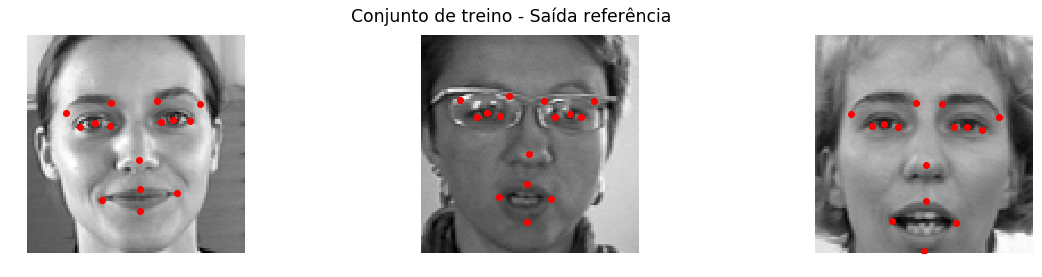

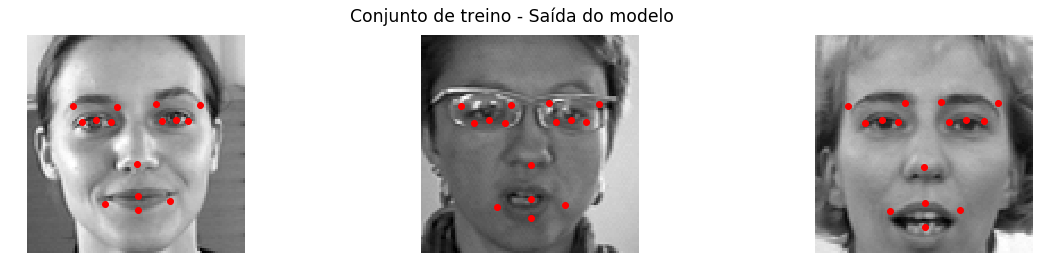

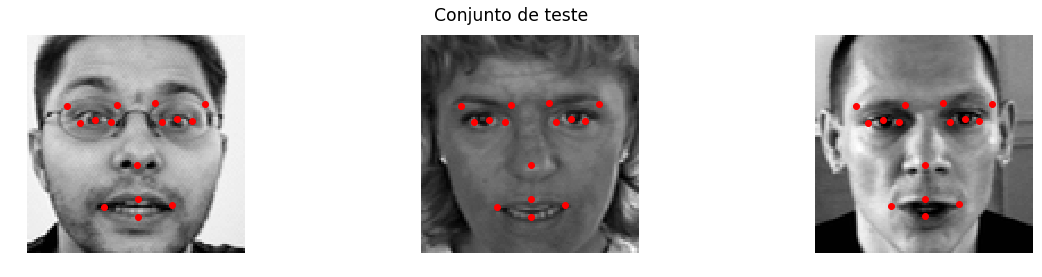

In [51]:
def plot_result(x, y, title, rescale=False):
    plot.figure(figsize=(20, 4))
    plot.gray()
    for i in range(3):
        imgs = x[i].reshape(96,96)
        plot.subplot(1, 3, i+1)
        if rescale:
            points = y[i].reshape(15,2)*48 + 48
        else:
            points = y[i].reshape(15,2)
        plot.scatter(points[:,0], points[:,1], c='r')
        plot.imshow(imgs)
        plot.axis('off')
    plot.suptitle(title, fontsize='xx-large')
    plot.show()
    
plot_result(X_numpy[9:12], y_numpy[9:12], 'Conjunto de treino - Saída referência')
plot_result(X_numpy[9:12], model(Variable(X_train[9:12])).data.numpy(), 'Conjunto de treino - Saída do modelo', rescale=True)
plot_result(X_test[:3], y_test[:3], 'Conjunto de teste', rescale=True)